In [1]:
"""

f(R) gravity emulator: for fast generation of P_mg/P_lcdm


Requires the following installations:

1. R (R studio is the easiest option: https://www.rstudio.com/products/rstudio/download/).
Installing R packages is easy, in R studio, command install.packages("package_name") works
(https://www.dummies.com/programming/r/how-to-install-load-and-unload-packages-in-r/)
The following R packages are required:
    1a. RcppCNPy
    1b. DiceKriging
    1c. GPareto

2. rpy2 -- which runs R under the hood (pip install rpy2 should work)
# http://rpy.sourceforge.net/rpy2/doc-2.1/html/index.html
# conda install -c r rpy2

Built by N. Ramachandra and M. Binois 
"""

##### Generic packages ###############
import numpy as np
import matplotlib.pylab as plt
import time
import glob
import os


##### MG Emulator import ####
### includes R importing using importr

import MGemulator as emu


####### PLOTTING SETTINGS #####
from itertools import cycle
import matplotlib.ticker as ticker
from matplotlib import gridspec


plt.rc('text', usetex=True)  # Slower
plt.rc('axes',labelsize= 10)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


In [2]:
############################# PARAMETERS ##############################
nRankMax = 8 ## Number of basis vectors in truncated PCA
del_idx =  [5, 25, 4, 42]  ## holdouts for testing

############################# INPUT FILES ##############################

dataDir = "./Data/" ## Data folder
plotsDir = "./Plots/" ## Data folder

paramIn = dataDir + 'mg.design'  ## parameter file
fileIn = dataDir + ['ratios.txt', 'PMG.txt'][0]
GPmodel = '"R_GP_model_flat_' + str(nRankMax) + '.RData"'  ## Double and single quotes are necessary
## DELETE the GPmodels or provide a new name if you want a new calculation

################################# Loading files ########################

loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
parameter_array_all = np.loadtxt(paramIn)

########################## Deleting hold-out from training ##############


PmPl = np.delete(PmPl_all, del_idx, axis = 0)
parameter_array = np.delete(parameter_array_all, del_idx, axis = 0)


####################### porting to R backend #######################

nr, nc = PmPl[:,:].shape
y_train = emu.ro.r.matrix(PmPl[:,:], nrow=nr, ncol=nc)
emu.ro.r.assign("y_train2", y_train)
emu.r('dim(y_train2)')

nr, nc = parameter_array[:,:].shape
u_train = emu.ro.r.matrix(parameter_array[:,:], nrow=nr, ncol=nc)
emu.ro.r.assign("u_train2", u_train)
emu.r('dim(u_train2)')

46,5


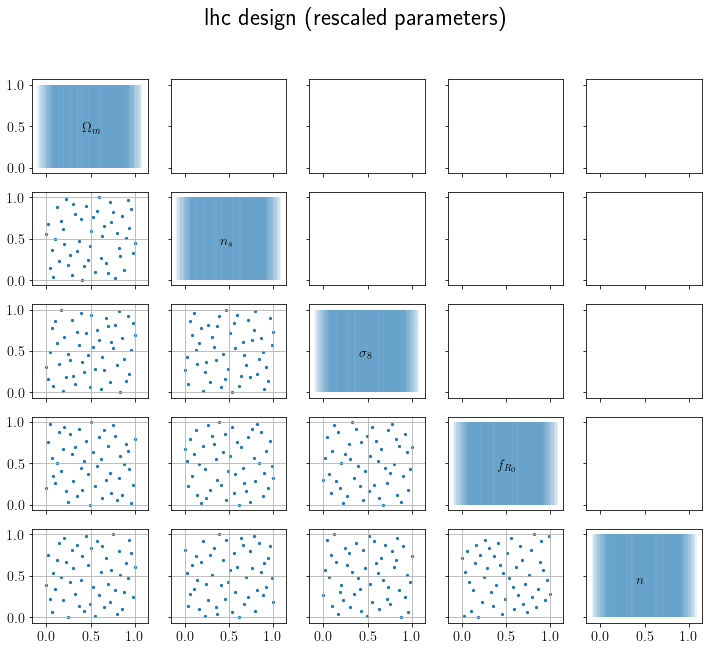

In [3]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

def rescale01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))

lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(12, 10) )
    plt.suptitle('lhc design (rescaled parameters)', fontsize = 24)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


plot_params(lhd)

In [4]:
#################### PCA DECOMPOSITION DONE AGAIN ##############

emu.PCA_decomp(nRank = nRankMax)

#################### LOADING TRAINED GP MODEL ##############

emu.GP_model_load(model = GPmodel)

R[write to console]: Loading required package: foreach



Time per emulation 0.092  s
Time per emulation 0.076  s
Time per emulation 0.068  s
Time per emulation 0.107  s


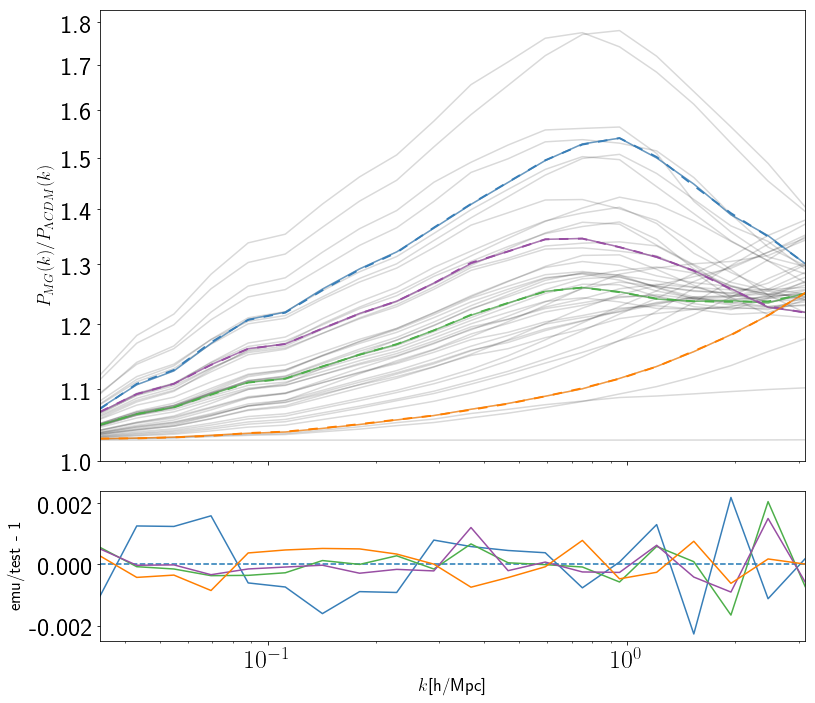

In [5]:
##################################### TESTING ##################################
plt.rc('font', size=18)  # 

PlotPrior = True

if PlotPrior:

    plt.figure(999, figsize=(14, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 18)

    ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 18)
    ax1.axhline(y=0, ls='dashed')


    ax0.set_yscale('log')
    ax0.set_xscale('log')
    ax1.set_xscale('log')

    ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)
#     ax1.set_ylim(-3e-3, 3e-3)

    ax0.plot(kvals, PmPl.T, alpha=0.15, color='k')

    start, end = ax0.get_ylim()
    ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
    ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))


    ax0.set_xlim(kvals[0], kvals[-1])
    ax1.set_xlim(kvals[0], kvals[-1])
    ax0.set_xticklabels([])


color_id = 0
for x_id in del_idx:
    color_id = color_id + 1

    time0 = time.time()
    x_decodedGPy = emu.GP_predict(parameter_array[x_id])  ## input parameters
    time1 = time.time()
    print('Time per emulation %0.3f' % (time1 - time0), ' s')
    x_test = PmPl[x_id]

    ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=plt.cm.Set1(color_id))
    ax0.plot(kvals, x_test, alpha=0.7, label='test', color=plt.cm.Set1(color_id))

    ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=plt.cm.Set1(color_id))


plt.savefig(plotsDir + "Emu.png",  bbox_inches="tight", dpi=200)

plt.show()

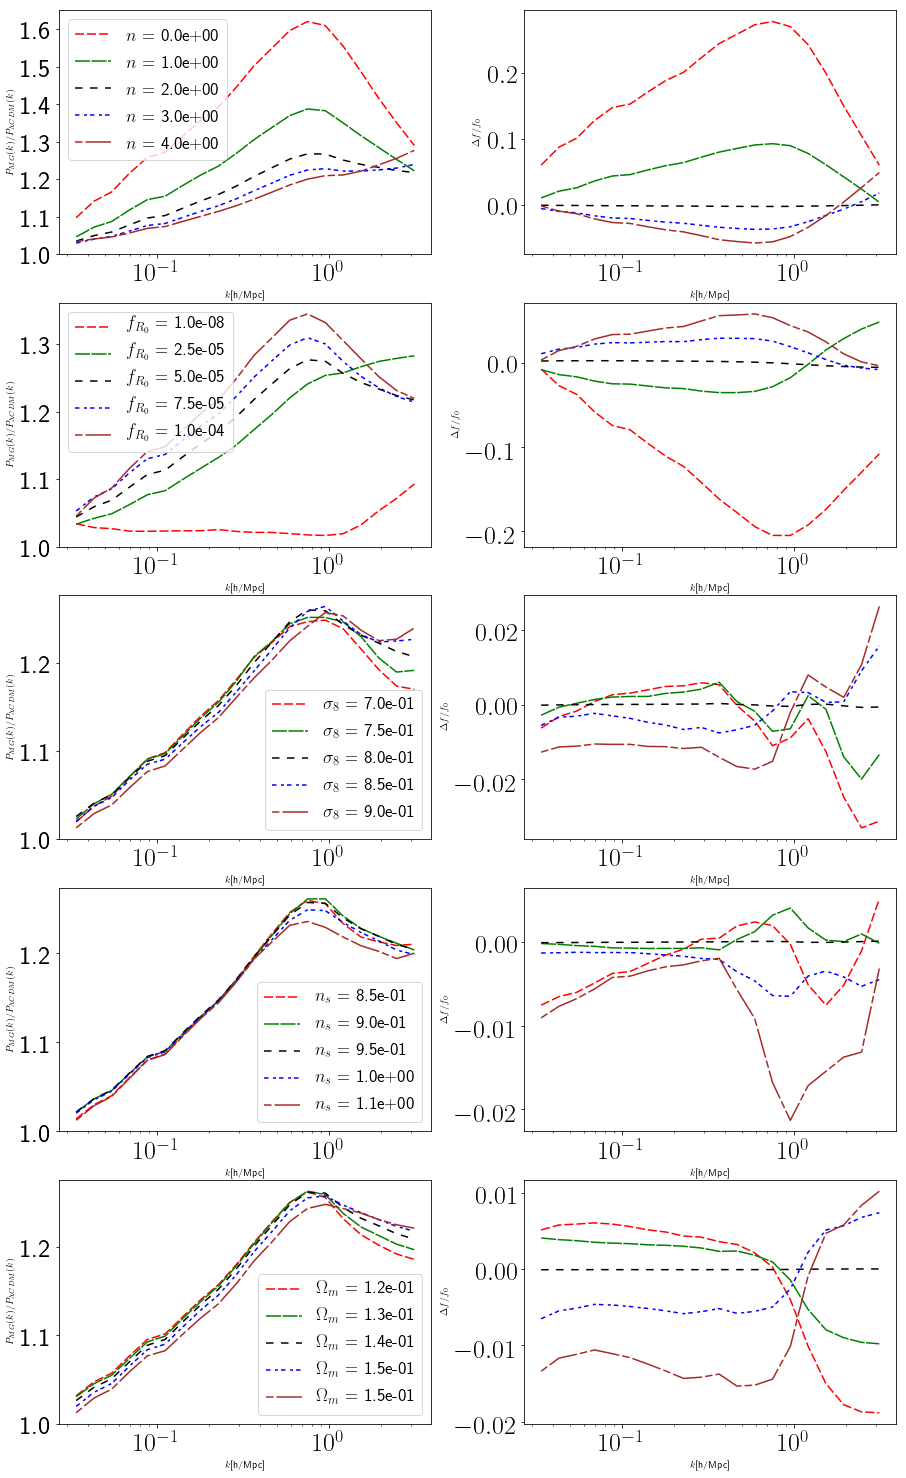

In [6]:
PlotCls = True

if PlotCls:
    
    numPlots = 5

    fig, ax = plt.subplots(5,2, figsize = (15,26))
    plt.subplots_adjust(wspace=0.25)
    
    allMax = np.max(parameter_array, axis = 0)
    allMin = np.min(parameter_array, axis = 0)
    allMean = np.mean(parameter_array, axis = 0)
    Pk_mean = emu.GP_predict(allMean) 
    
    for paramNo in range(5):
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  
            x_decodedGPy = emu.GP_predict(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])

            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()

            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')

            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity.png",  bbox_inches="tight", dpi=200)

plt.show()

In [7]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4, p5 = theta

    new_params = np.array([p1, p2, p3, p4, p5])

    model = emu.GP_predict(new_params)
    # return -0.5 * (np.sum(((y - model) / yerr) ** 2.))
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))

In [11]:
######### CALLING THE EMULATOR ##############
#### input arguments: (Om, ns, s8, fR0, n)
#### output: P_mg/P_lcdm in 20 bins
#### Example: 

emu.GP_predict([0.3, 1.0, 0.8, 1e-5, 2.5])

array([0.85583749, 0.83609817, 0.82596794, 0.80377844, 0.78604188,
       0.78034344, 0.76280988, 0.74624074, 0.7341315 , 0.71352178,
       0.6980963 , 0.68297138, 0.6715404 , 0.67129862, 0.68483018,
       0.73642476, 0.80500479, 0.86352922, 0.92105246, 0.97377332])

In [13]:
kvals.min(), kvals.max()

(0.03403, 3.129401)